In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
!pip install optuna

In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.6 MB/s eta 0:00:00


In [ ]:
import optuna as opt
import shap

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/projectDatabase/heart.csv")
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
df.dtypes

,0
age,int64
sex,int64
cp,int64
trtbps,int64
chol,int64
fbs,int64
restecg,int64
thalachh,int64
exng,int64
oldpeak,float64


In [ ]:
string_col=df.select_dtypes("string").columns.to_list()
num_col=df.columns.to_list()


for col in string_col:
    num_col.remove(col)
num_col.remove("output")

In [ ]:
px.imshow(df.corr(),title="Correlation Plot of the Heat Failure Prediction")

In [ ]:
# Shows the Distribution of Heat Diseases with respect to male and female
fig=px.histogram(df,
                 x="output",
                 color="sex",
                 hover_data=df.columns,
                 title="Distribution of Heart Diseases",
                 barmode="group")
fig.show()

In [ ]:
fig=px.histogram(df,
                 x="cp",
                 color="sex",
                 hover_data=df.columns,
                 title="Types of Chest Pain"
                )
fig.show()

In [ ]:
fig=px.histogram(df,
                 x="restecg",
                 color="output",
                 hover_data=df.columns,
                 title="Distribution of Resting ECG")
fig.show()

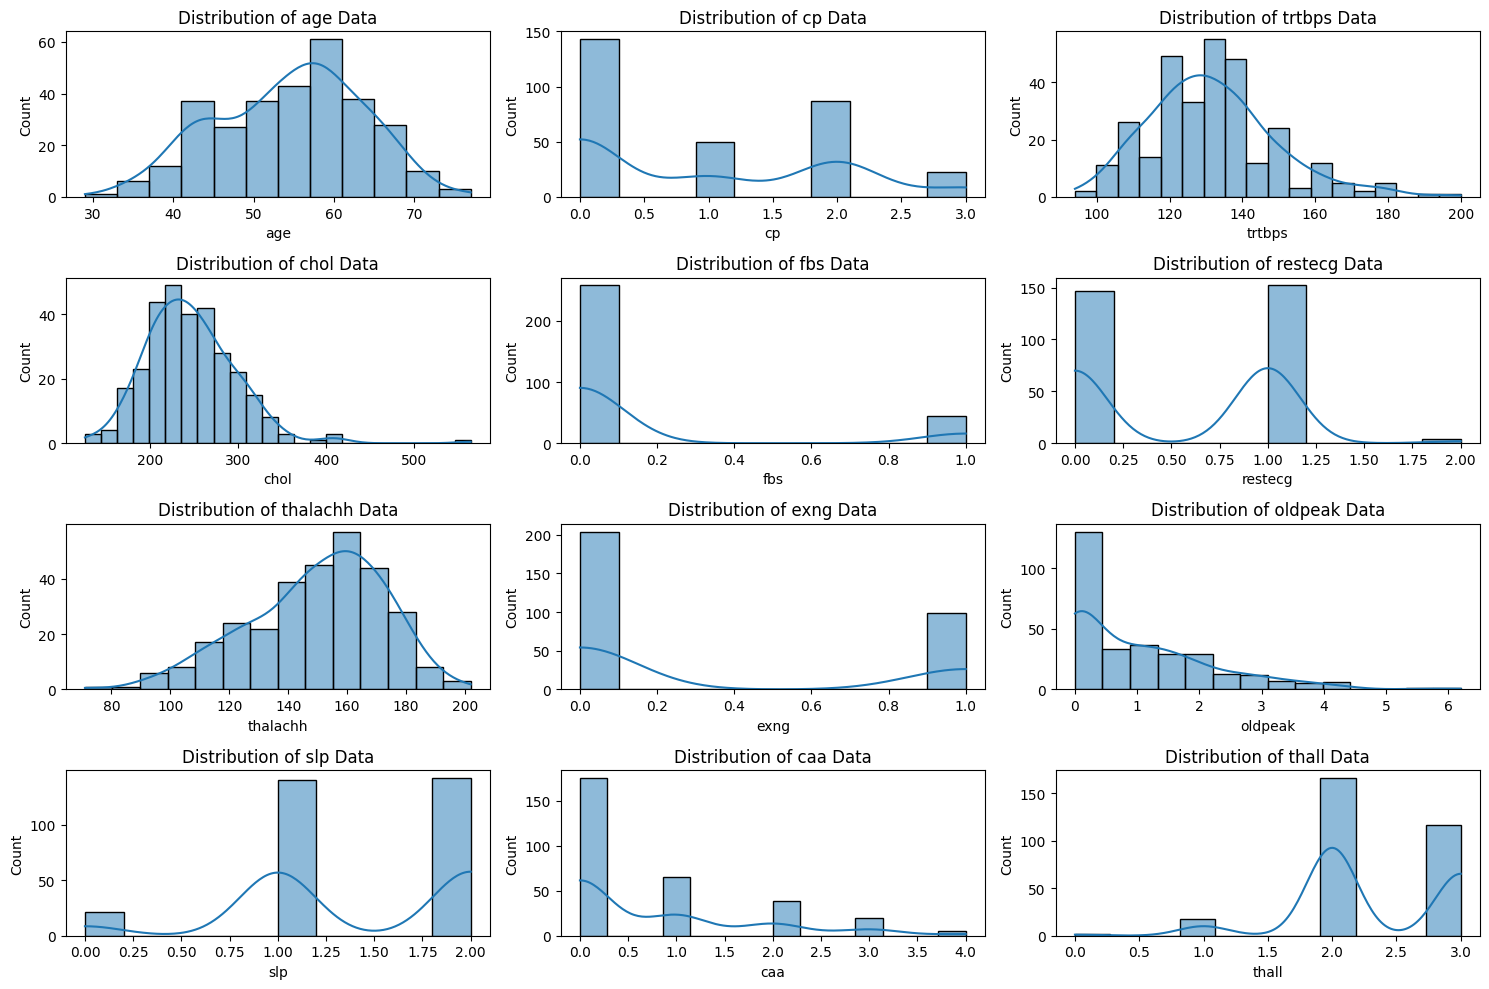

In [ ]:
plt.figure(figsize=(15,10))
for i,col in enumerate(df.drop(['output','sex'], axis=1).columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col],kde=True)
    plt.tight_layout()
    plt.plot()

In [ ]:
df2 = pd.get_dummies(df['cp'])
df3 = pd.get_dummies(df['restecg'])
df2.head()

,0,1,2,3
0,False,False,False,True
1,False,False,True,False
2,False,True,False,False
3,False,True,False,False
4,True,False,False,False


In [ ]:
df2['cp0'] = df2[0].map({True: 1, False: 0})
df2['cp1'] = df2[1].map({True: 1, False: 0})
df2['cp2'] = df2[2].map({True: 1, False: 0})
df2['cp3'] = df2[3].map({True: 1, False: 0})
df3['restecg0'] = df3[0].map({True: 1, False: 0})
df3['restecg1'] = df3[1].map({True: 1, False: 0})
df3['restecg2'] = df3[2].map({True: 1, False: 0})
df2.head()

,0,1,2,3,cp0,cp1,cp2,cp3
0,False,False,False,True,0,0,0,1
1,False,False,True,False,0,0,1,0
2,False,True,False,False,0,1,0,0
3,False,True,False,False,0,1,0,0
4,True,False,False,False,1,0,0,0


now, show the last 4 columns in df2

In [ ]:
df[['cp0','cp1','cp2','cp3']] = df2.iloc[:, -4:]
df[['restecg0','restecg1','restecg2']] = df3.iloc[:, -3:]

In [ ]:
colunas_normalizadas = ['age', 'trtbps', 'chol', 'thalachh']
colunas_binarias = ['sex', 'cp0','cp1','cp2','cp3', 'fbs','restecg0','restecg1','restecg2', 'exng', 'slp', 'caa','thall', 'oldpeak']

In [ ]:
df.drop(['cp','restecg'], axis=1, inplace=True)

In [ ]:
df.describe()

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,slp,caa,thall,output,cp0,cp1,cp2,cp3,restecg0,restecg1,restecg2
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,131.623762,246.264026,0.148515,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554,0.471947,0.165017,0.287129,0.075908,0.485149,0.501650,0.013201
std,9.082101,0.466011,17.538143,51.830751,0.356198,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835,0.500038,0.371809,0.453171,0.265288,0.500606,0.500824,0.114325
min,29.000000,0.000000,94.000000,126.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,120.000000,211.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,55.000000,1.000000,130.000000,240.000000,0.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,61.000000,1.000000,140.000000,274.500000,0.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,77.000000,1.000000,200.000000,564.000000,1.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Robust Scaler
scaler = RobustScaler()
scaled_data = scaler.fit_transform(df[colunas_normalizadas])

In [ ]:
df2 = pd.DataFrame(scaled_data, columns=colunas_normalizadas)
df2[colunas_binarias]=df[colunas_binarias]
df2['output']=df['output']
df2.head()

,age,trtbps,chol,thalachh,sex,cp0,cp1,cp2,cp3,fbs,restecg,exng,slp,caa,thall,oldpeak,output
0,0.592593,0.75,-0.110236,-0.092308,1,0,0,0,1,1,0,0,0,0,1,2.3,1
1,-1.333333,0.00,0.157480,1.046154,1,0,0,1,0,0,1,0,0,0,2,3.5,1
2,-1.037037,0.00,-0.566929,0.584615,0,0,1,0,0,0,0,0,2,0,2,1.4,1
3,0.074074,-0.50,-0.062992,0.769231,1,0,1,0,0,0,1,0,2,0,2,0.8,1
4,0.148148,-0.50,1.795276,0.307692,0,1,0,0,0,0,1,1,2,0,2,0.6,1


In [ ]:
X = df.drop('output', axis=1)
y = df['output']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
lgb_model = lgb.LGBMClassifier(objective='binary', metric='auc', num_leaves=31, learning_rate=0.05, n_estimators=100)

In [ ]:
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LGBMClassifier(learning_rate=0.05, metric='auc', objective='binary')

In [ ]:
y_pred = lgb_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

In [ ]:
def objective(trial):
    # Define hyperparameters to optimize
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'num_leaves': trial.suggest_int('num_leaves', 2, 128),
        'learning_rate': trial.suggest_int('learning_rate', 2, 20, log=True)/100,
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'subsample': trial.suggest_int('subsample', 5, 10)/10,
        'colsample_bytree': trial.suggest_int('colsample_bytree', 5, 10)/10,
        'max_depth': trial.suggest_int('max_depth', 3, 10)
    }

    # Create and train LightGBM model
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)

    # Evaluate model on validation set
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [ ]:
# Create a study object
study = opt.create_study(direction='maximize')

# Run optimization
study.optimize(objective, n_trials=100)

# Get the best trial
best_params = study.best_params
best_value = study.best_value

print("Best parameters:", best_params)
print("Best value:", best_value)

[I 2024-08-30 01:20:53,444] A new study created in memory with name: no-name-71e4c9ea-cb35-41cd-b71e-691b304de283


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2024-08-30 01:20:53,855] Trial 0 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 76, 'learning_rate': 9, 'n_estimators': 619, 'subsample': 7, 'colsample_bytree': 10, 'max_depth': 3}. Best is trial 0 with value: 0.8360655737704918.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:20:54,389] Trial 1 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 28, 'learning_rate': 2, 'n_estimators': 734, 'subsample': 10, 'colsample_bytree': 7, 'max_depth': 5}. Best is trial 0 with value: 0.8360655737704918.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:20:54,517] Trial 2 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 73, 'learning_rate': 17, 'n_estimators': 152, 'subsample': 9, 'colsample_bytree': 7, 'max_depth': 5}. Best is trial 0 with value: 0.8360655737704918.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:20:55,187] Trial 3 finished with value: 0.819672131147541 and parameters: {'num_leaves': 22, 'learning_rate': 5, 'n_estimators': 915, 'subsample': 6, 'colsample_bytree': 6, 'max_depth': 10}. Best is trial 0 with value: 0.8360655737704918.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:20:55,581] Trial 4 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 79, 'learning_rate': 3, 'n_estimators': 527, 'subsample': 7, 'colsample_bytree': 6, 'max_depth': 9}. Best is trial 0 with value: 0.8360655737704918.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:20:55,740] Trial 5 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 12, 'learning_rate': 3, 'n_estimators': 208, 'subsample': 8, 'colsample_bytree': 5, 'max_depth': 5}. Best is trial 5 with value: 0.8524590163934426.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-08-30 01:20:55,999] Trial 6 finished with value: 0.8688524590163934 and parameters: {'num_leaves': 107, 'learning_rate': 2, 'n_estimators': 346, 'subsample': 6, 'colsample_bytree': 6, 'max_depth': 9}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:20:56,330] Trial 7 finished with value: 0.8032786885245902 and parameters: {'num_leaves': 88, 'learning_rate': 2, 'n_estimators': 473, 'subsample': 6, 'colsample_bytree': 9, 'max_depth': 4}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:20:56,746] Trial 8 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 101, 'learning_rate': 15, 'n_estimators': 575, 'subsample': 7, 'colsample_bytree': 7, 'max_depth': 6}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:20:57,224] Trial 9 finished with value: 0.819672131147541 and parameters: {'num_leaves': 77, 'learning_rate': 7, 'n_estimators': 670, 'subsample': 5, 'colsample_bytree': 7, 'max_depth': 6}. Best is trial 6 with value: 0.8688524590163934.
[I 2024-08-30 01:20:57,502] Trial 10 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 126, 'learning_rate': 4, 'n_estimators': 323, 'subsample': 5, 'colsample_bytree': 5, 'max_depth': 8}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-08-30 01:20:57,632] Trial 11 finished with value: 0.8688524590163934 and parameters: {'num_leaves': 44, 'learning_rate': 3, 'n_estimators': 42, 'subsample': 9, 'colsample_bytree': 5, 'max_depth': 8}. Best is trial 6 with value: 0.8688524590163934.
[I 2024-08-30 01:20:57,750] Trial 12 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 46, 'learning_rate': 2, 'n_estimators': 72, 'subsample': 9, 'colsample_bytree': 5, 'max_depth': 8}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-08-30 01:20:58,034] Trial 13 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 54, 'learning_rate': 3, 'n_estimators': 334, 'subsample': 10, 'colsample_bytree': 6, 'max_depth': 8}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-08-30 01:20:58,180] Trial 14 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 112, 'learning_rate': 4, 'n_estimators': 58, 'subsample': 8, 'colsample_bytree': 8, 'max_depth': 10}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2024-08-30 01:20:58,526] Trial 15 finished with value: 0.8688524590163934 and parameters: {'num_leaves': 41, 'learning_rate': 2, 'n_estimators': 354, 'subsample': 9, 'colsample_bytree': 6, 'max_depth': 7}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:20:58,737] Trial 16 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 61, 'learning_rate': 3, 'n_estimators': 239, 'subsample': 6, 'colsample_bytree': 5, 'max_depth': 9}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-08-30 01:20:58,880] Trial 17 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 3, 'learning_rate': 11, 'n_estimators': 424, 'subsample': 8, 'colsample_bytree': 8, 'max_depth': 9}. Best is trial 6 with value: 0.8688524590163934.
[I 2024-08-30 01:20:58,982] Trial 18 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 128, 'learning_rate': 5, 'n_estimators': 33, 'subsample': 6, 'colsample_bytree': 6, 'max_depth': 7}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] S

[I 2024-08-30 01:20:59,557] Trial 19 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 94, 'learning_rate': 4, 'n_estimators': 810, 'subsample': 9, 'colsample_bytree': 5, 'max_depth': 10}. Best is trial 6 with value: 0.8688524590163934.
[I 2024-08-30 01:20:59,804] Trial 20 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 38, 'learning_rate': 6, 'n_estimators': 182, 'subsample': 5, 'colsample_bytree': 6, 'max_depth': 8}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-08-30 01:21:00,123] Trial 21 finished with value: 0.8688524590163934 and parameters: {'num_leaves': 35, 'learning_rate': 2, 'n_estimators': 367, 'subsample': 9, 'colsample_bytree': 6, 'max_depth': 7}. Best is trial 6 with value: 0.8688524590163934.
[I 2024-08-30 01:21:00,420] Trial 22 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 52, 'learning_rate': 2, 'n_estimators': 273, 'subsample': 10, 'colsample_bytree': 5, 'max_depth': 7}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-08-30 01:21:00,812] Trial 23 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 63, 'learning_rate': 3, 'n_estimators': 431, 'subsample': 8, 'colsample_bytree': 6, 'max_depth': 9}. Best is trial 6 with value: 0.8688524590163934.
[I 2024-08-30 01:21:01,006] Trial 24 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 43, 'learning_rate': 2, 'n_estimators': 134, 'subsample': 9, 'colsample_bytree': 8, 'max_depth': 7}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2024-08-30 01:21:01,301] Trial 25 finished with value: 0.8688524590163934 and parameters: {'num_leaves': 19, 'learning_rate': 4, 'n_estimators': 296, 'subsample': 10, 'colsample_bytree': 7, 'max_depth': 8}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:01,690] Trial 26 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 32, 'learning_rate': 3, 'n_estimators': 403, 'subsample': 7, 'colsample_bytree': 5, 'max_depth': 6}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:02,146] Trial 27 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 110, 'learning_rate': 2, 'n_estimators': 501, 'subsample': 8, 'colsample_bytree': 6, 'max_depth': 9}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:02,298] Trial 28 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 50, 'learning_rate': 8, 'n_estimators': 99, 'subsample': 9, 'colsample_bytree': 9, 'max_depth': 8}. Best is trial 6 with value: 0.8688524590163934.
[I 2024-08-30 01:21:02,366] Trial 29 finished with value: 0.8688524590163934 and parameters: {'num_leaves': 70, 'learning_rate': 4, 'n_estimators': 15, 'subsample': 7, 'colsample_bytree': 10, 'max_depth': 7}. Best is trial 6 with value: 0.8688524590163934.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-08-30 01:21:02,864] Trial 30 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 59, 'learning_rate': 10, 'n_estimators': 613, 'subsample': 10, 'colsample_bytree': 5, 'max_depth': 4}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2024-08-30 01:21:03,179] Trial 31 finished with value: 0.8688524590163934 and parameters: {'num_leaves': 37, 'learning_rate': 2, 'n_estimators': 377, 'subsample': 9, 'colsample_bytree': 6, 'max_depth': 7}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:03,482] Trial 32 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 28, 'learning_rate': 2, 'n_estimators': 356, 'subsample': 9, 'colsample_bytree': 6, 'max_depth': 6}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:03,706] Trial 33 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 40, 'learning_rate': 3, 'n_estimators': 239, 'subsample': 9, 'colsample_bytree': 7, 'max_depth': 7}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[I 2024-08-30 01:21:04,104] Trial 34 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 17, 'learning_rate': 2, 'n_estimators': 463, 'subsample': 10, 'colsample_bytree': 7, 'max_depth': 8}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:04,536] Trial 35 finished with value: 0.819672131147541 and parameters: {'num_leaves': 32, 'learning_rate': 5, 'n_estimators': 556, 'subsample': 8, 'colsample_bytree': 6, 'max_depth': 9}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:04,762] Trial 36 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 9, 'learning_rate': 3, 'n_estimators': 716, 'subsample': 8, 'colsample_bytree': 6, 'max_depth': 6}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-08-30 01:21:04,948] Trial 37 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 28, 'learning_rate': 2, 'n_estimators': 155, 'subsample': 9, 'colsample_bytree': 5, 'max_depth': 7}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-08-30 01:21:05,565] Trial 38 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 86, 'learning_rate': 16, 'n_estimators': 851, 'subsample': 7, 'colsample_bytree': 7, 'max_depth': 5}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:05,809] Trial 39 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 24, 'learning_rate': 14, 'n_estimators': 264, 'subsample': 10, 'colsample_bytree': 6, 'max_depth': 10}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:06,189] Trial 40 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 48, 'learning_rate': 7, 'n_estimators': 202, 'subsample': 6, 'colsample_bytree': 5, 'max_depth': 4}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-08-30 01:21:06,628] Trial 41 finished with value: 0.8688524590163934 and parameters: {'num_leaves': 21, 'learning_rate': 4, 'n_estimators': 296, 'subsample': 10, 'colsample_bytree': 7, 'max_depth': 8}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:06,901] Trial 42 finished with value: 0.8688524590163934 and parameters: {'num_leaves': 16, 'learning_rate': 5, 'n_estimators': 308, 'subsample': 10, 'colsample_bytree': 7, 'max_depth': 8}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:07,705] Trial 43 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 35, 'learning_rate': 3, 'n_estimators': 990, 'subsample': 9, 'colsample_bytree': 7, 'max_depth': 8}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-08-30 01:21:08,039] Trial 44 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 69, 'learning_rate': 4, 'n_estimators': 382, 'subsample': 10, 'colsample_bytree': 6, 'max_depth': 9}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2024-08-30 01:21:08,455] Trial 45 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 56, 'learning_rate': 6, 'n_estimators': 502, 'subsample': 9, 'colsample_bytree': 8, 'max_depth': 7}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:08,604] Trial 46 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 9, 'learning_rate': 3, 'n_estimators': 345, 'subsample': 9, 'colsample_bytree': 7, 'max_depth': 8}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-08-30 01:21:08,990] Trial 47 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 44, 'learning_rate': 4, 'n_estimators': 450, 'subsample': 6, 'colsample_bytree': 6, 'max_depth': 9}. Best is trial 6 with value: 0.8688524590163934.
[I 2024-08-30 01:21:09,127] Trial 48 finished with value: 0.8688524590163934 and parameters: {'num_leaves': 118, 'learning_rate': 12, 'n_estimators': 101, 'subsample': 8, 'colsample_bytree': 5, 'max_depth': 6}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:09,255] Trial 49 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 3, 'learning_rate': 5, 'n_estimators': 548, 'subsample': 10, 'colsample_bytree': 6, 'max_depth': 10}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] S

[I 2024-08-30 01:21:09,494] Trial 50 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 24, 'learning_rate': 18, 'n_estimators': 242, 'subsample': 5, 'colsample_bytree': 9, 'max_depth': 8}. Best is trial 6 with value: 0.8688524590163934.
[I 2024-08-30 01:21:09,593] Trial 51 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 72, 'learning_rate': 4, 'n_estimators': 44, 'subsample': 7, 'colsample_bytree': 10, 'max_depth': 7}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:09,751] Trial 52 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 98, 'learning_rate': 6, 'n_estimators': 95, 'subsample': 6, 'colsample_bytree': 10, 'max_depth': 7}. Best is trial 6 with value: 0.8688524590163934.
[I 2024-08-30 01:21:09,835] Trial 53 finished with value: 0.8688524590163934 and parameters: {'num_leaves': 84, 'learning_rate': 4, 'n_estimators': 15, 'subsample': 7, 'colsample_bytree': 8, 'max_depth': 8}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2024-08-30 01:21:10,016] Trial 54 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 68, 'learning_rate': 3, 'n_estimators': 150, 'subsample': 8, 'colsample_bytree': 9, 'max_depth': 6}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2024-08-30 01:21:10,276] Trial 55 finished with value: 0.819672131147541 and parameters: {'num_leaves': 42, 'learning_rate': 5, 'n_estimators': 291, 'subsample': 7, 'colsample_bytree': 10, 'max_depth': 7}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:10,497] Trial 56 finished with value: 0.8688524590163934 and parameters: {'num_leaves': 92, 'learning_rate': 7, 'n_estimators': 207, 'subsample': 6, 'colsample_bytree': 5, 'max_depth': 9}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-08-30 01:21:10,821] Trial 57 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 76, 'learning_rate': 4, 'n_estimators': 421, 'subsample': 5, 'colsample_bytree': 8, 'max_depth': 3}. Best is trial 6 with value: 0.8688524590163934.
[I 2024-08-30 01:21:10,941] Trial 58 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 107, 'learning_rate': 2, 'n_estimators': 65, 'subsample': 7, 'colsample_bytree': 7, 'max_depth': 5}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:11,036] Trial 59 finished with value: 0.8688524590163934 and parameters: {'num_leaves': 32, 'learning_rate': 6, 'n_estimators': 12, 'subsample': 9, 'colsample_bytree': 6, 'max_depth': 7}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-08-30 01:21:11,233] Trial 60 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 57, 'learning_rate': 8, 'n_estimators': 179, 'subsample': 8, 'colsample_bytree': 5, 'max_depth': 8}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-08-30 01:21:11,568] Trial 61 finished with value: 0.8688524590163934 and parameters: {'num_leaves': 35, 'learning_rate': 2, 'n_estimators': 379, 'subsample': 9, 'colsample_bytree': 6, 'max_depth': 7}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:11,894] Trial 62 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 48, 'learning_rate': 2, 'n_estimators': 368, 'subsample': 9, 'colsample_bytree': 6, 'max_depth': 6}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:12,232] Trial 63 finished with value: 0.8688524590163934 and parameters: {'num_leaves': 38, 'learning_rate': 2, 'n_estimators': 331, 'subsample': 9, 'colsample_bytree': 6, 'max_depth': 7}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-08-30 01:21:12,745] Trial 64 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 20, 'learning_rate': 3, 'n_estimators': 597, 'subsample': 10, 'colsample_bytree': 7, 'max_depth': 7}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:13,169] Trial 65 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 122, 'learning_rate': 2, 'n_estimators': 466, 'subsample': 8, 'colsample_bytree': 6, 'max_depth': 7}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:13,580] Trial 66 finished with value: 0.8688524590163934 and parameters: {'num_leaves': 26, 'learning_rate': 2, 'n_estimators': 418, 'subsample': 8, 'colsample_bytree': 5, 'max_depth': 9}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:13,870] Trial 67 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 64, 'learning_rate': 4, 'n_estimators': 253, 'subsample': 9, 'colsample_bytree': 6, 'max_depth': 8}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:14,074] Trial 68 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 16, 'learning_rate': 5, 'n_estimators': 127, 'subsample': 10, 'colsample_bytree': 9, 'max_depth': 6}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2024-08-30 01:21:14,485] Trial 69 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 53, 'learning_rate': 3, 'n_estimators': 399, 'subsample': 9, 'colsample_bytree': 6, 'max_depth': 8}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-08-30 01:21:15,078] Trial 70 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 35, 'learning_rate': 3, 'n_estimators': 648, 'subsample': 9, 'colsample_bytree': 7, 'max_depth': 10}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-08-30 01:21:15,393] Trial 71 finished with value: 0.8688524590163934 and parameters: {'num_leaves': 11, 'learning_rate': 4, 'n_estimators': 309, 'subsample': 10, 'colsample_bytree': 7, 'max_depth': 8}. Best is trial 6 with value: 0.8688524590163934.
[I 2024-08-30 01:21:15,695] Trial 72 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 21, 'learning_rate': 4, 'n_estimators': 287, 'subsample': 10, 'colsample_bytree': 8, 'max_depth': 8}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2024-08-30 01:21:16,074] Trial 73 finished with value: 0.8688524590163934 and parameters: {'num_leaves': 80, 'learning_rate': 5, 'n_estimators': 343, 'subsample': 10, 'colsample_bytree': 7, 'max_depth': 7}. Best is trial 6 with value: 0.8688524590163934.
[I 2024-08-30 01:21:16,325] Trial 74 finished with value: 0.8688524590163934 and parameters: {'num_leaves': 29, 'learning_rate': 5, 'n_estimators': 225, 'subsample': 10, 'colsample_bytree': 7, 'max_depth': 9}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-08-30 01:21:16,747] Trial 75 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 40, 'learning_rate': 2, 'n_estimators': 519, 'subsample': 9, 'colsample_bytree': 6, 'max_depth': 8}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:17,089] Trial 76 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 46, 'learning_rate': 3, 'n_estimators': 319, 'subsample': 10, 'colsample_bytree': 7, 'max_depth': 7}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-08-30 01:21:17,503] Trial 77 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 31, 'learning_rate': 4, 'n_estimators': 445, 'subsample': 9, 'colsample_bytree': 5, 'max_depth': 9}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-08-30 01:21:17,920] Trial 78 finished with value: 0.8688524590163934 and parameters: {'num_leaves': 14, 'learning_rate': 20, 'n_estimators': 489, 'subsample': 6, 'colsample_bytree': 6, 'max_depth': 8}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:18,185] Trial 79 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 20, 'learning_rate': 7, 'n_estimators': 281, 'subsample': 9, 'colsample_bytree': 8, 'max_depth': 7}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:18,543] Trial 80 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 37, 'learning_rate': 6, 'n_estimators': 360, 'subsample': 10, 'colsample_bytree': 6, 'max_depth': 6}. Best is trial 6 with value: 0.8688524590163934.
[I 2024-08-30 01:21:18,668] Trial 81 finished with value: 0.8688524590163934 and parameters: {'num_leaves': 8, 'learning_rate': 5, 'n_estimators': 303, 'subsample': 10, 'colsample_bytree': 7, 'max_depth': 8}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:19,052] Trial 82 finished with value: 0.8688524590163934 and parameters: {'num_leaves': 26, 'learning_rate': 5, 'n_estimators': 397, 'subsample': 10, 'colsample_bytree': 7, 'max_depth': 8}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:19,269] Trial 83 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 17, 'learning_rate': 6, 'n_estimators': 183, 'subsample': 10, 'colsample_bytree': 7, 'max_depth': 7}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:19,535] Trial 84 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 23, 'learning_rate': 4, 'n_estimators': 254, 'subsample': 10, 'colsample_bytree': 8, 'max_depth': 9}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:19,667] Trial 85 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 5, 'learning_rate': 13, 'n_estimators': 323, 'subsample': 9, 'colsample_bytree': 7, 'max_depth': 8}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No furthe

[I 2024-08-30 01:21:19,903] Trial 86 finished with value: 0.8688524590163934 and parameters: {'num_leaves': 103, 'learning_rate': 5, 'n_estimators': 226, 'subsample': 10, 'colsample_bytree': 7, 'max_depth': 7}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:20,246] Trial 87 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 42, 'learning_rate': 4, 'n_estimators': 378, 'subsample': 8, 'colsample_bytree': 6, 'max_depth': 8}. Best is trial 6 with value: 0.8688524590163934.
[I 2024-08-30 01:21:20,404] Trial 88 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 13, 'learning_rate': 8, 'n_estimators': 87, 'subsample': 6, 'colsample_bytree': 5, 'max_depth': 7}. Best is trial 6 with value: 0.8688524590163934.
[I 2024-08-30 01:21:20,529] Trial 89 finished with value: 0.8688524590163934 and parameters: {'num_leaves': 49, 'learning_rate': 2, 'n_estimators': 39, 'subsample': 7, 'colsample_bytree': 6, 'max_depth': 9}. Best is trial 6 with value: 0.8688524590163934.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-08-30 01:21:20,721] Trial 90 finished with value: 0.8852459016393442 and parameters: {'num_leaves': 114, 'learning_rate': 11, 'n_estimators': 125, 'subsample': 5, 'colsample_bytree': 7, 'max_depth': 8}. Best is trial 90 with value: 0.8852459016393442.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-08-30 01:21:20,891] Trial 91 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 123, 'learning_rate': 12, 'n_estimators': 116, 'subsample': 6, 'colsample_bytree': 7, 'max_depth': 8}. Best is trial 90 with value: 0.8852459016393442.
[I 2024-08-30 01:21:21,018] Trial 92 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 112, 'learning_rate': 9, 'n_estimators': 64, 'subsample': 5, 'colsample_bytree': 7, 'max_depth': 8}. Best is trial 90 with value: 0.8852459016393442.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:21,313] Trial 93 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 111, 'learning_rate': 15, 'n_estimators': 267, 'subsample': 5, 'colsample_bytree': 7, 'max_depth': 8}. Best is trial 90 with value: 0.8852459016393442.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-08-30 01:21:21,527] Trial 94 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 18, 'learning_rate': 9, 'n_estimators': 152, 'subsample': 5, 'colsample_bytree': 7, 'max_depth': 7}. Best is trial 90 with value: 0.8852459016393442.


[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-08-30 01:21:21,854] Trial 95 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 92, 'learning_rate': 11, 'n_estimators': 350, 'subsample': 5, 'colsample_bytree': 6, 'max_depth': 8}. Best is trial 90 with value: 0.8852459016393442.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2024-08-30 01:21:22,137] Trial 96 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 117, 'learning_rate': 11, 'n_estimators': 295, 'subsample': 9, 'colsample_bytree': 8, 'max_depth': 9}. Best is trial 90 with value: 0.8852459016393442.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:22,358] Trial 97 finished with value: 0.8688524590163934 and parameters: {'num_leaves': 116, 'learning_rate': 10, 'n_estimators': 180, 'subsample': 9, 'colsample_bytree': 5, 'max_depth': 7}. Best is trial 90 with value: 0.8852459016393442.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-30 01:21:22,482] Trial 98 finished with value: 0.8524590163934426 and parameters: {'num_leaves': 106, 'learning_rate': 8, 'n_estimators': 44, 'subsample': 6, 'colsample_bytree': 6, 'max_depth': 8}. Best is trial 90 with value: 0.8852459016393442.
[I 2024-08-30 01:21:22,626] Trial 99 finished with value: 0.8360655737704918 and parameters: {'num_leaves': 30, 'learning_rate': 7, 'n_estimators': 83, 'subsample': 7, 'colsample_bytree': 6, 'max_depth': 7}. Best is trial 90 with value: 0.8852459016393442.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [ ]:
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    num_leaves=125,
    learning_rate=0.11,
    n_estimators=125,
    subsample=0.5,
    colsample_bytree= 0.7,
    max_depth= 4
    )

In [ ]:
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 241
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LGBMClassifier(colsample_bytree=0.7, learning_rate=0.11, max_depth=4,
               metric='auc', n_estimators=125, num_leaves=125,
               objective='binary', subsample=0.5)

In [ ]:
y_pred = lgb_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8524590163934426
Precision: 0.8709677419354839
Recall: 0.84375
F1-score: 0.8571428571428571


In [ ]:
# Assuming you have a trained LightGBM model 'lgb_model' and your data 'X_test'
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)


/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



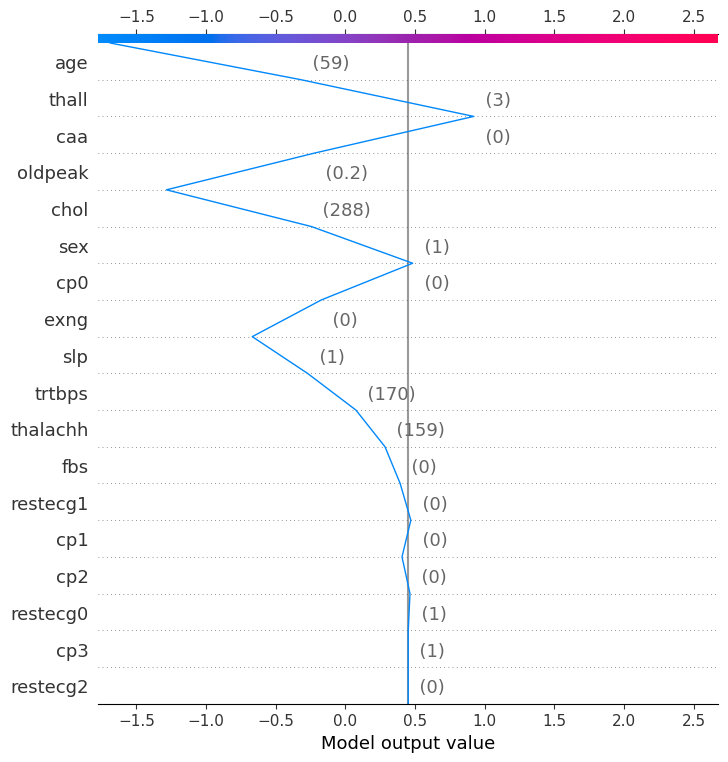

In [ ]:
shap.decision_plot(explainer.expected_value, shap_values[1], X_test.iloc[1])

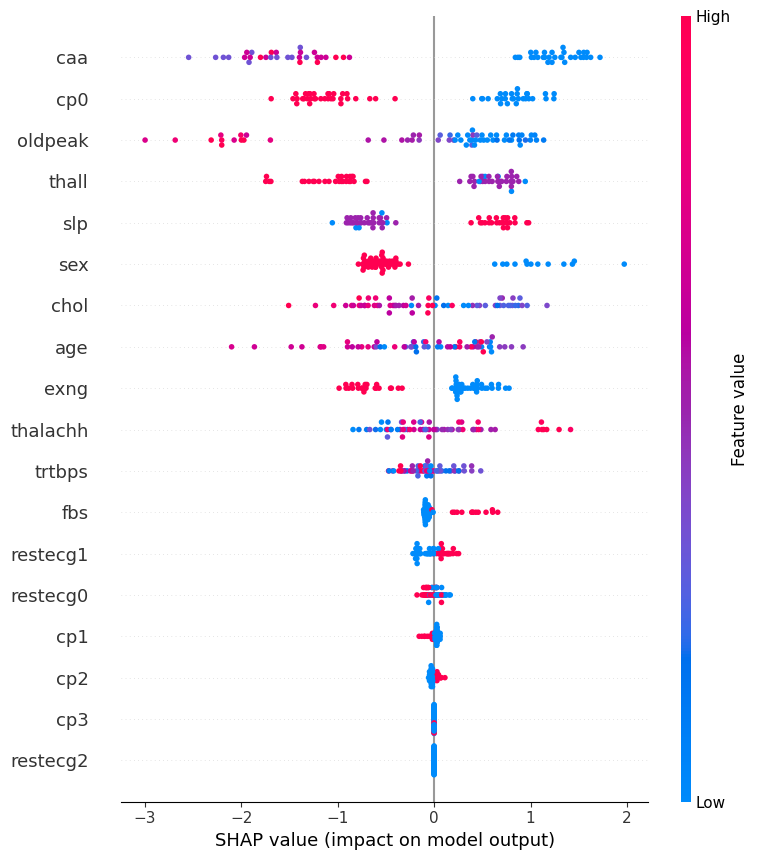

In [ ]:
# Create a summary plot
shap.summary_plot(shap_values, X_test)

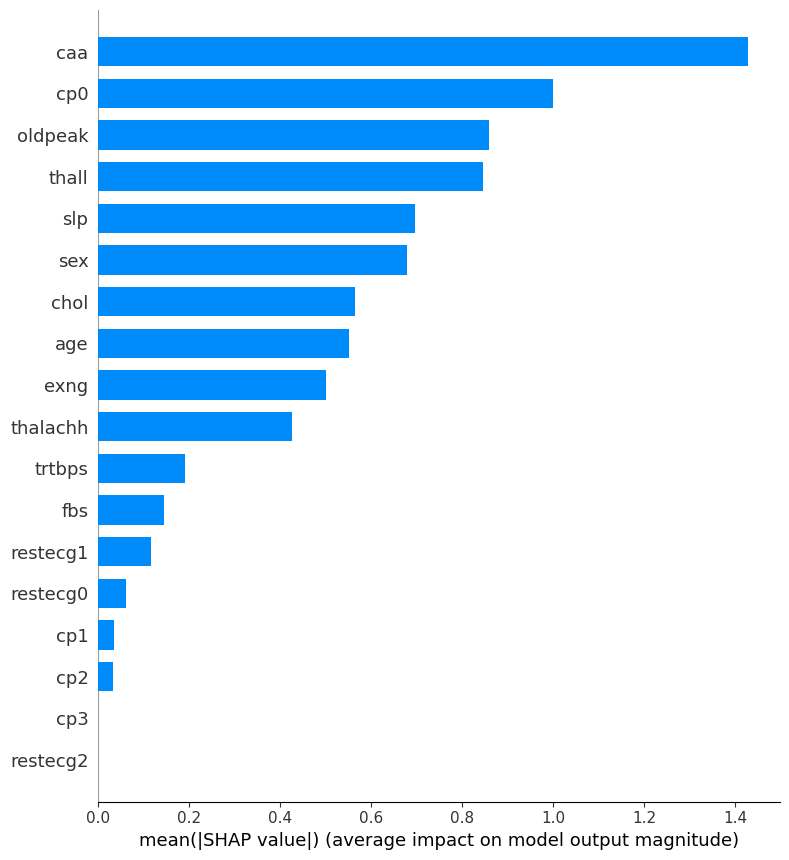

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

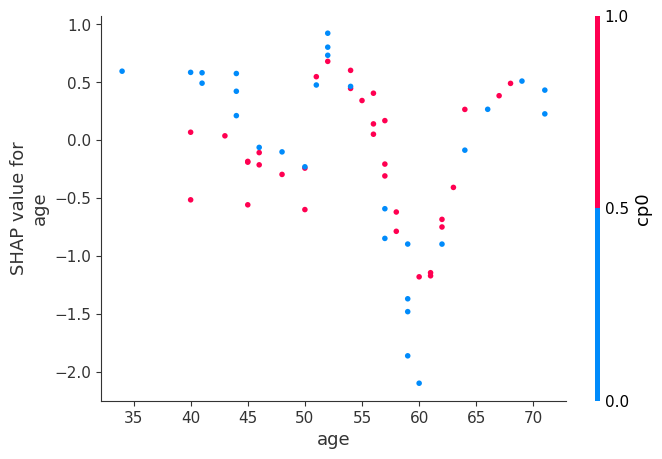

In [ ]:
shap.dependence_plot(0, shap_values, X_test)

In [ ]:
if 'Prediction' in df.columns:
    df.drop('Prediction', axis=1, inplace=True)
df['Prediction'] = lgb_model.predict(df.drop('output', axis=1))

In [ ]:
print("Total de Alertas: ", df[ df['Prediction'] == 1].count()['output'])
print("Acertos: ", df[ df['Prediction'] == 1].sum()['output'])

Total de Alertas:  164
Acertos:  160.0


In [ ]:
print("Alerta Negativo: ", df[ df['Prediction'] == 0].count()['output'])
print("Falso negativo: ", df[ df['Prediction'] == 0].sum()['output'])

Alerta Negativo:  139
Falso negativo:  5.0


In [ ]:
print("Acertou: ", df[ df['Prediction'] == df['output']].count()['output'])
print("Errou: ", df[ df['Prediction'] != df['output']].count()['output'])
print("Percentual: ", df[ df['Prediction'] == df['output']].count()['output'] / df.count()['output'])

Acertou:  294
Errou:  9
Percentual:  0.9702970297029703


In [ ]:
print(df['output'].value_counts()[0])
print(df['output'].value_counts()[1])

138
165
